In [352]:
import numpy as np
from qiskit.quantum_info import random_statevector

# 2 Qubits

In [353]:
n_qubits = 2

### Generate "unkown" state you want to learn

In [354]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [ ]:
smaller_bases = False
smallest_bases = True

if smallest_bases is True:
    zero_zero = np.array([1, 0, 0, 0]).reshape(-1, 1)
    zero_one = np.array([0, 1, 0, 0]).reshape(-1, 1)
    one_zero = np.array([0, 0, 1, 0]).reshape(-1, 1)
    one_one = np.array([0, 0, 0, 1]).reshape(-1, 1)

    # phase on zero_one
    zero_one_plus = 1/np.sqrt(2) * np.array([1, 1, 0, 0]).reshape(-1, 1)
    zero_one_i = 1/np.sqrt(2) * np.array([1, 1j, 0, 0]).reshape(-1, 1)

    # phase on one_zero
    one_zero_plus = 1/np.sqrt(2) * np.array([1, 0, 1, 0]).reshape(-1, 1)
    one_zero_i = 1/np.sqrt(2) * np.array([1, 0, 1j, 0]).reshape(-1, 1)

    # phase on one_one

    # try changing this (Bell state, hard/impossible to measure directly) 
    one_one_plus = 1/np.sqrt(2) * np.array([1, 0, 0, 1]).reshape(-1, 1)
    one_one_i = 1/np.sqrt(2) * np.array([1, 0, 0, 1j]).reshape(-1, 1)

    # to (TODO: rename)
    one_one_plus = 1/np.sqrt(2) * np.array([0, 0, 1, 1]).reshape(-1, 1)
    one_one_i = 1/np.sqrt(2) * np.array([0, 0, 1, 1j]).reshape(-1, 1)


    basis_states = [zero_zero, zero_one, one_zero, one_one,
                    zero_one_plus, zero_one_i,
                    one_zero_plus, one_zero_i,
                    one_one_plus, one_one_i
                    ]
elif smaller_bases is True:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, i]
else:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [356]:
# 2 qubits
if smallest_bases is True:
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qubit_measurement_operators = measurement_operators
else: 
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qubit_measurement_operators = []
    for qubit_1_op in measurement_operators:
        for qubit_2_op in measurement_operators:
            two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [357]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [358]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [359]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [360]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [361]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [362]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [363]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [364]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [365]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [366]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9954182676215646


### Plot Density Matrices

In [367]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [368]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

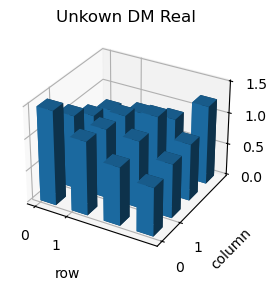

[[1.48315799 1.15896699 0.91701802 0.76331952]
 [1.15896699 1.09309563 1.0560315  0.85120327]
 [0.91701802 1.0560315  1.18449136 0.89576024]
 [0.76331952 0.85120327 0.89576024 1.23925502]]


In [369]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

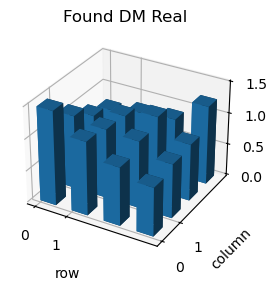

[[1.48298519 1.15848804 0.91715945 0.76560245]
 [1.15848804 1.09315229 1.05581706 0.85299518]
 [0.91715945 1.05581706 1.184703   0.89597514]
 [0.76560245 0.85299518 0.89597514 1.23915952]]


In [370]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

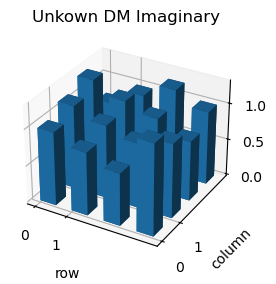

[[1.         0.85960984 0.7132031  1.24409082]
 [1.14039016 1.         0.88152717 1.0115382 ]
 [1.2867969  1.11847283 1.         0.81758686]
 [0.75590918 0.9884618  1.18241314 1.        ]]


In [371]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

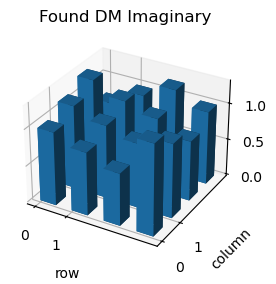

[[1.         0.85991595 0.71383379 1.24038599]
 [1.14008405 1.         0.88147079 1.01196331]
 [1.28616621 1.11852921 1.         0.81876018]
 [0.75961401 0.98803669 1.18123982 1.        ]]


In [372]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [373]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [374]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[ 0.09818046+0.68812687j]
 [-0.16764451+0.25493323j]
 [-0.42532643-0.05990645j]
 [ 0.29954601-0.38668748j]]
prob_0 [0.48315799]
prob_1 [0.09309563]


#### original psi from density matrix, testing that it matches psi

In [375]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.69509567+0.j          0.228698  +0.20197242j -0.1193821 +0.41260062j
 -0.34050058-0.35116147j]
prob_0 0.48315799229280715
prob_1 0.09309563286587688


#### statevector from reconstructed dm

In [376]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [-0.69563793+0.j         -0.22913598-0.20170357j  0.11933047-0.41370949j
  0.33968862+0.34945183j]
prob_0 0.4839121328674659
prob_1 0.09318762817343372


### State vector fidelity

In [377]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [378]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999949881822392